<a href="https://colab.research.google.com/github/jansoe/dl_workshop/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
# Es lohnt sich zu überprüfen, ob man auch wirklich eine GPU bekommen hat.
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Autoencoder


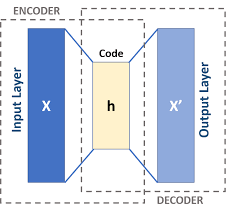
(Quelle:https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png)


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython import display

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [ ]:
# adding a color channel 
train_images = train_images[:,:,:,np.newaxis].astype('float32')
# and scale to 0-1
train_images_01 = train_images / 255.

test_images = test_images[:,:,:,np.newaxis]
test_images_01 = test_images / 255.

train_images_01.shape

(60000, 28, 28, 1)

## Encoder

The Encoder is similar to a classification network. Only there is no final classification head at the end.

In [ ]:
latent_dim = 8

encoder = tf.keras.Sequential(
    name='encoder',
    layers = [
        layers.InputLayer(input_shape=(28, 28, 1)),
        layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.Flatten(),
        layers.Dense(latent_dim),
        ]
    )

## Decoder

The Decoder is taking an input and reconstructing an image from this

In [ ]:
decoder = tf.keras.Sequential(
    name = 'decoder', 
    layers = [
        layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(units=7*7*32, activation=tf.nn.relu),
        layers.Reshape(target_shape=(7, 7, 32)),
        layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(filters=1,  kernel_size=3, strides=1, padding="same", activation='sigmoid'),
        ]
    )

## Autoencoder

Combining Encoder-Autoencoder



In [ ]:

# Posibility 1
autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.output))

# Posibility 2
#encoder_model = encoder(encoder.input)  # hack for the best graph
#autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder_model))

# Posibility 3
#autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

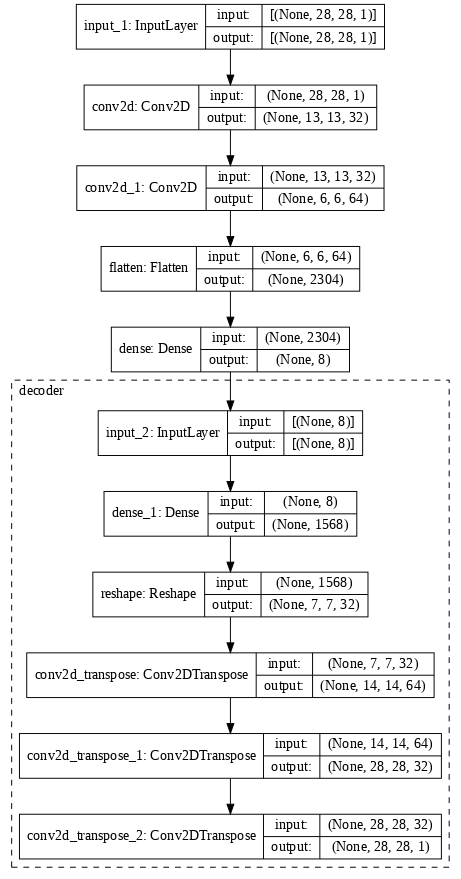

In [ ]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=70, expand_nested=True)

initial model predictions

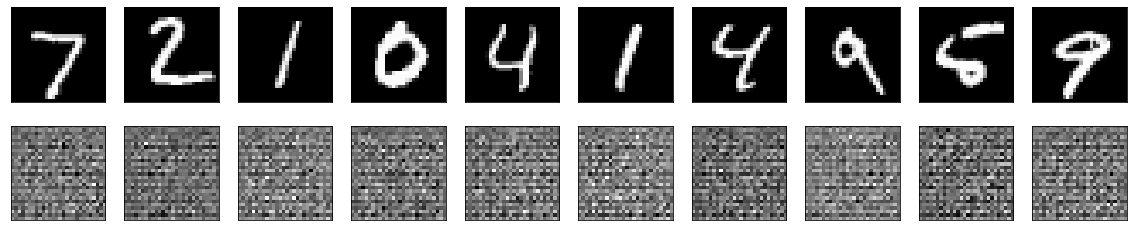

In [ ]:
decoded_imgs = autoencoder.predict(test_images_01)

n_plot = 10
plt.figure(figsize=(20, 4))
for i in range(n_plot):
    # display original
    ax = plt.subplot(2, n_plot, i+1)
    plt.imshow(test_images_01[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n_plot, i+n_plot+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Training



In [ ]:
autoencoder.fit(
    x = train_images_01, 
    y = train_images_01, # input and output are the same (i.e. autoencoder)
    epochs=40,
    batch_size=256,
    shuffle=True,
    validation_data=(test_images_01, test_images_01)
)

Epoch 1/40
235/235 [==============================] - 11s 14ms/step - loss: 0.3691 - val_loss: 0.1621
Epoch 2/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1531 - val_loss: 0.1348
Epoch 3/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1332 - val_loss: 0.1275
Epoch 4/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1272 - val_loss: 0.1232
Epoch 5/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1233 - val_loss: 0.1208
Epoch 6/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1213 - val_loss: 0.1195
Epoch 7/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1196 - val_loss: 0.1181
Epoch 8/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1181 - val_loss: 0.1171
Epoch 9/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1176 - val_loss: 0.1168
Epoch 10/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1168 - val_l

ouput after the training

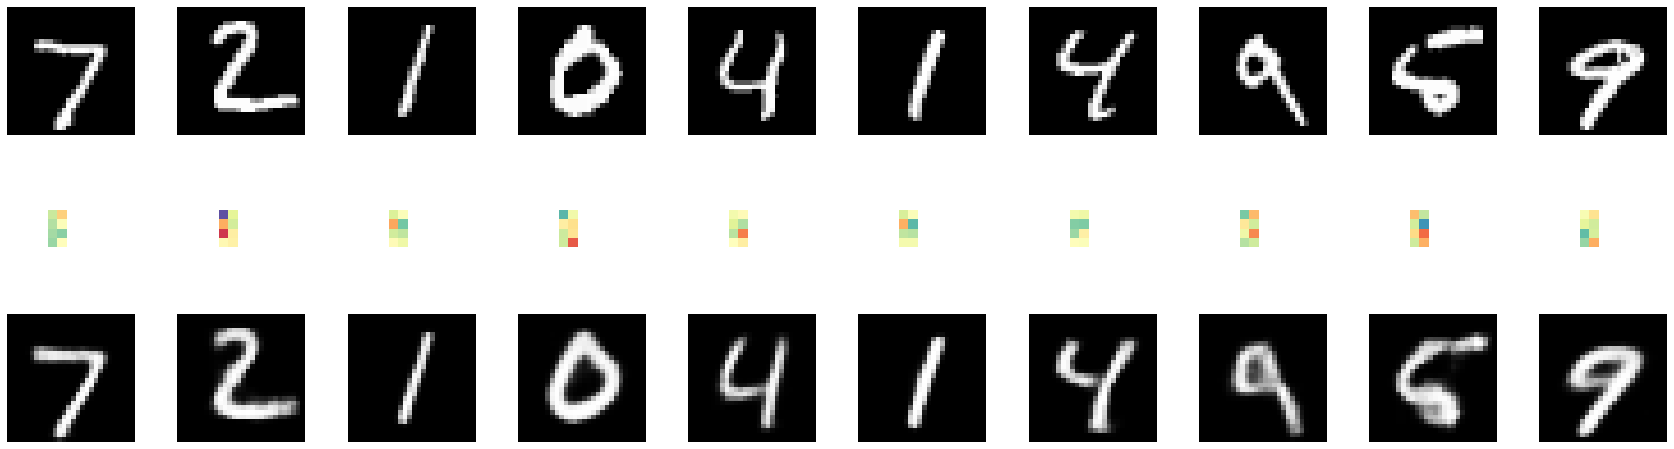

In [ ]:
encoded_imgs = encoder.predict(test_images_01)
de_encoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(30, 8))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_images_01[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # encodint original
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 2), cmap=plt.cm.Spectral, vmin=-10, vmax=10)
    plt.xlim((-5, 9))
    plt.ylim((-5, 9))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(de_encoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

# Exploring the latent Space

We can feed the decoder any input

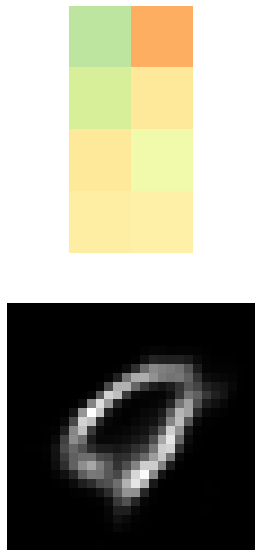

In [ ]:
np.random.seed(44)
random_encoding = (np.random.rand(latent_dim)-0.5)*10

random_img = decoder.predict(random_encoding[np.newaxis]).reshape((28,28))

plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.imshow(random_encoding.reshape((4,2)),  cmap=plt.cm.Spectral, vmin=-10, vmax=10)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(random_img, cmap='gray')
_ = plt.axis('off')

## Shifts in latent space

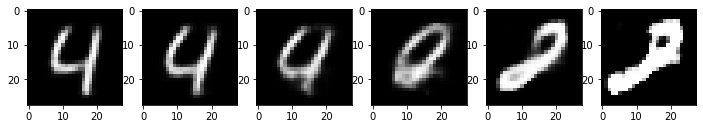

In [ ]:
code = encoder.predict(test_images_01[4][None,:,:,:])
direction = np.random.randn(*code.shape)
displacements = [0,1,2,4,8,16]
plt.figure(figsize=(12,10))
for i,d in enumerate(displacements):
    plt.subplot(1,len(displacements),i+1)
    img = decoder.predict(code+direction*d)
    _ = plt.imshow(img.squeeze(), cmap='gray')

## Distances in the latent space

Text(0.5, 1.0, 'Codes')

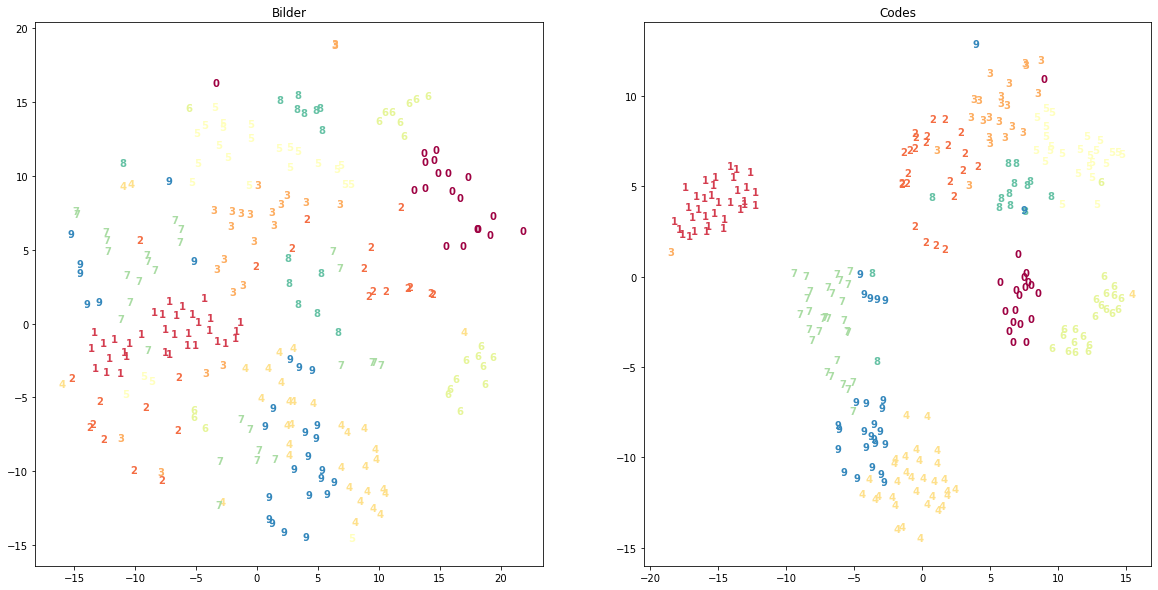

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

tsne = TSNE(n_components=2)
fig = plt.figure(figsize=(20,10))

# raw images
encodings2d = tsne.fit_transform(test_images[:250].reshape((250, -1)))
ax = plt.subplot(121)
ax.scatter(*encodings2d.T, alpha=0)
for i in range(250):
    ax.text(*encodings2d[i], test_labels[i], color=plt.cm.Spectral(test_labels[i]/10), fontweight='heavy')
plt.title('Bilder')

# codes
encodings2d = pca.fit_transform(encoded_imgs[:250])
ax = plt.subplot(122)
ax.scatter(*encodings2d.T, alpha=0)
for i in range(250):
    ax.text(*encodings2d[i], test_labels[i], color=plt.cm.Spectral(test_labels[i]/10), fontweight='heavy')
plt.title('Codes')

## Morphing in latent space

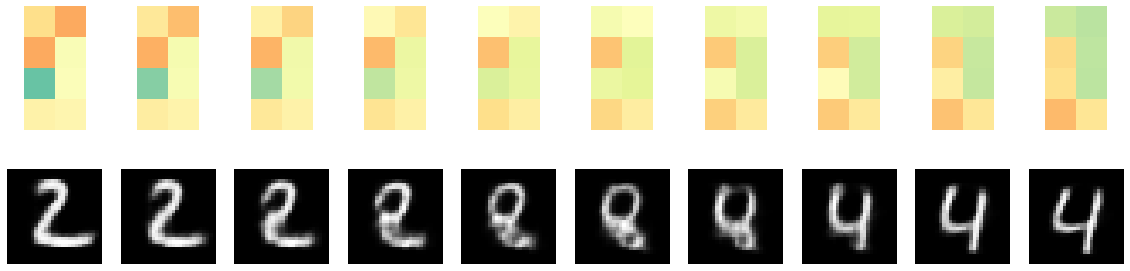

In [ ]:
start_img_number = 1
end_img_number = 4
morph_steps = 10

plt.figure(figsize=(20,5))
for i in range(morph_steps):
    alpha = i /(morph_steps-1)
    morphed = (1-alpha) * encoded_imgs[start_img_number] + alpha * encoded_imgs[end_img_number]
    decoded = decoder.predict(morphed[np.newaxis]).reshape((28,28))

    plt.subplot(2,morph_steps,i+1)
    plt.imshow(morphed.reshape((4,2)), cmap=plt.cm.Spectral, vmin=-10, vmax=10)
    plt.axis('off')
    plt.subplot(2,morph_steps,morph_steps+i+1)
    plt.imshow(decoded)
    plt.axis('off')

### Task
- Get the latent representation for 2 of the test images (ecoded images)
- Add both representations and gereate the resulting image with the decoder
- Compare the result to directy adding the 2 images in pixel space